# Random forest model

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predicand)

In [3]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Predictors. Load everything from relevant directory.

In [4]:
files = [path + "demand_predictors/" + i for i in os.listdir(path + "demand_predictors/")]

In [5]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [6]:
pred_ds.data_vars

Data variables:
    t2min     (region, time) float64 nan 289.1 289.3 290.0 ... 281.9 287.8 287.9
    t2m3      (region, time) float64 nan nan 293.0 293.7 ... 290.2 287.9 289.7
    msdwswrf  (region, time) float64 nan 293.4 257.6 298.1 ... 281.5 249.9 299.6
    cdd4      (region, time) float64 nan nan nan ... 0.221 0.221 -0.001519
    t2m       (region, time) float64 292.7 292.8 293.6 ... 287.1 289.8 292.2
    cdd3      (region, time) float64 nan nan 0.2243 ... -0.001518 -0.001519
    cdd       (region, time) float64 0.2843 0.1455 ... 5.631e-05 5.632e-05
    hdd4      (region, time) float64 nan nan nan 0.383 ... 2.467 2.565 2.572
    hdd       (region, time) float64 1.053 0.5182 0.3264 ... 4.067 1.35 0.06106
    mtpr      (region, time) float64 2.842e-05 4.244e-05 ... 1.614e-05 6.045e-06
    rh        (region, time) float64 92.39 91.39 91.05 ... 90.65 93.94 92.18
    w10       (region, time) float64 3.489 3.602 3.166 ... 1.758 3.059 3.369
    t2max     (region, time) float64 nan 297.4 2

## Define some functions

For a given region, get the data into a dataframe

In [7]:
def to_dataframe(target_da, predictors_ds, region):
    """
    Convert xarray data to pandas dataframe.
    """
    # Predictors to array
    predictors_arr = predictors_ds.sel(region=region, time=target_da["time"]).to_array("variable")
    # Data array of target and predictors
    da = xr.concat([
        predictors_arr,
        target_da.sel(region=region).expand_dims({"variable": ["demand"]})
    ], dim="variable")
    # Dataframe
    df = pd.DataFrame(
        da.transpose(),
        columns=da["variable"],
        index=target_da["time"]
    )
    return df

Set up a time column to either indicate:
1. day of week
2. weekend/weekday binary
3. winter/summer/transition
4. transition/(winter,summer) binary

In [8]:
def add_time_column(df, method):
    """
    Add a time column to df.
    
    df: dataframe to add to
    method: str indicating which method to use. Currently 'is_weekend',
            'month_sin', 'month_cos', 'month_int', 'season_int'
    """
    if method == "is_weekend":
        # Bool for weekend day or weekday
        new_col = (df.index.weekday > 4).astype("int16")
    elif method == "month_sin":
        new_col = np.sin((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_cos":
        new_col = np.cos((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_int":
        new_col = df.index.month
    elif method == "season_int":
        new_col = df.index.month % 12 // 3 + 1
    else:
        raise ValueError("Incorrect 'method'.")
    
    df[method] = new_col
    return df

Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [9]:
def split(df, target_name, test_size, random_state):
    """
    Apply train_test_split to dataframe
    
    df: pandas dataframe
    target_name: column name of df to target
    test_size: float, proportion of data to test
    random_state: int
    """
    y = np.array(df[target_name]) # target
    X = np.array(df.drop(target_name, axis=1)) # predictors
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

Train model and make predictions

In [10]:
def predict_forest(train_y, train_X, test_X, random_state, n_estimators=100, n_jobs=None):
    """
    Instantiate and fit a random forest model, return predictions.
    
    train_y: target for training set
    train_X: predictors for training set
    test_X: predictors for test set
    random_state: number for replication
    n_estimators: number of trees
    n_jobs: number of jobs to run in parallel
    """
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs)
    rf.fit(train_X, train_y)
    return rf, rf.predict(test_X)

## Apply to the data

*Note:* I've tried various permutations of seasonal indices (months and seasons), but they are all of low variable importance. This is presumably because seasonal information is contained in temperature.

In [11]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
time_cols = ["is_weekend"]

region_dfs = {}
for region in dem_da.region.values:
    df = to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [12]:
region_dfs["NSW"].head()

,demand,is_weekend,t2min,t2m3,msdwswrf,cdd4,t2m,cdd3,cdd,hdd4,hdd,mtpr,rh,w10,t2max,hdd3,t2m4
2010-01-01,189098.854210,0,293.135916,295.652358,164.218843,0.230228,296.525003,0.236526,0.176162,0.173212,0.000324,0.000087,93.658535,3.132796,299.244528,0.173511,295.379525
2010-01-02,213642.465012,1,290.967947,295.889085,229.810077,0.199591,295.424110,0.179770,0.087857,0.174805,0.008797,0.000108,94.196278,2.557276,300.501642,0.173751,295.595364
2010-01-03,194617.495814,1,290.609908,294.763146,148.300158,0.134740,292.339987,0.136942,0.007749,0.220479,0.236494,0.000024,93.812825,2.931974,294.826772,0.236721,295.001880
2010-01-04,189128.506616,0,289.493653,293.841889,238.270861,0.115388,293.761230,0.046391,0.060270,0.223888,0.019122,0.000006,91.860632,2.919768,296.801895,0.241564,294.512735
2010-01-05,191152.737418,0,291.541431,294.200035,329.752634,0.115776,296.498553,0.124774,0.215896,0.223851,-0.000134,0.000003,91.115371,2.041179,300.815600,0.238905,294.506123


In [13]:
# NEM_df.describe()

### Random forest for all regions

In [14]:
importance_df = pd.DataFrame(
    columns=dem_da["region"].values,
    index=region_dfs["NEM"].drop("demand", axis=1).columns
)
importance_dict = {}
for item in region_dfs.items():
    region = item[0]
    df = item[1]
    predictors_list = df.drop("demand", axis=1).columns
    
    train_X, test_X, train_y, test_y = split(
        df,
        "demand",
        test_size=0.2,
        random_state=1
    )
    rf, predictions = predict_forest(
        train_y,
        train_X,
        test_X,
        random_state=666,
        n_estimators=100,
        n_jobs=5
    )
    importance_df[region] = rf.feature_importances_
    importances = rf.feature_importances_
    importance_dict[region] = [(f, i) for f, i in zip(predictors_list, importances)]

In [15]:
importance_df.style.background_gradient(cmap='Blues')

,NSW,QLD,SA,TAS,VIC,NEM
is_weekend,0.066349,0.048905,0.045215,0.013197,0.099606,0.111474
t2min,0.044736,0.072358,0.052218,0.055596,0.051324,0.055495
t2m3,0.060198,0.191545,0.065513,0.127251,0.054247,0.049209
msdwswrf,0.067948,0.058611,0.081070,0.069244,0.072653,0.066950
cdd4,0.043952,0.059875,0.038165,0.053602,0.033365,0.043319
t2m,0.114313,0.078527,0.043706,0.041429,0.108205,0.114234
cdd3,0.050293,0.049390,0.040471,0.051266,0.036071,0.040681
cdd,0.068678,0.056575,0.062507,0.023113,0.071156,0.058041
hdd4,0.051743,0.047232,0.040280,0.053639,0.038003,0.044931
hdd,0.048923,0.047048,0.046712,0.049012,0.045615,0.068358


In [16]:
importance_df.mean(axis=1).sort_values(ascending=False)

t2max         0.125889
t2m3          0.091327
t2m           0.083402
msdwswrf      0.069413
hdd3          0.066132
is_weekend    0.064124
w10           0.059773
cdd           0.056678
rh            0.056121
t2min         0.055288
hdd           0.050945
hdd4          0.045971
cdd4          0.045380
cdd3          0.044695
t2m4          0.044280
mtpr          0.040580
dtype: float64

### Try drop-column

In [17]:
from sklearn.base import clone

In [18]:
def dropcol_importances(rf, X_train, y_train):
    """ From https://explained.ai/rf-importance/index.html """
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [90]:
rf = RandomForestRegressor(n_estimators=100, random_state=666, n_jobs=5, oob_score=True)

In [91]:
rf.fit(train_X, train_y)

RandomForestRegressor(n_jobs=5, oob_score=True, random_state=666)

In [92]:
df_train_X = pd.DataFrame(train_X, columns=predictors_list)

In [93]:
I = dropcol_importances(rf, df_train_X, train_y)

In [23]:
I

,Importance
Feature,
t2m,-0.007940
hdd3,-0.002733
w10,-0.002563
t2m4,-0.001557
mtpr,-0.000851
t2min,-0.000509
hdd,-0.000018
t2max,0.000317
t2m3,0.000777


In [24]:
df_train_X_2 = df_train_X.drop(
    ["t2m", "hdd3", "w10", "t2m4", "mtpr", "t2min", "hdd"], axis=1)

In [25]:
I = dropcol_importances(rf, df_train_X_2, train_y)

In [26]:
I

,Importance
Feature,
cdd4,0.000373
cdd3,0.001803
rh,0.002817
t2m3,0.006874
msdwswrf,0.008794
cdd,0.011532
t2max,0.011768
hdd4,0.012521
is_weekend,0.109257


# Performance scores

In [27]:
import matplotlib.pyplot as plt

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

In [29]:
def compute_scores(y_true, y_pred, metrics):
    """
    Compute scores for a variety of metrics.
    
    y_true: observations
    y_predict: predictions
    metrics: list of scores from sklearn.metrics
    """
    scores = []
    for metric in metrics:
        scores.append(metric(y_true, y_pred))
    return scores

In [30]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [31]:
def get_scores(region, to_drop):
    """
    Return scores of model trained with some predictors dropped.
    
    region: str
    to_drop: list of predictors to drop
    """
    df = region_dfs[region].drop(to_drop, axis=1)
    predictors_list = df.drop("demand", axis=1).columns

    train_X, test_X, train_y, test_y = split(
        df,
        "demand",
        test_size=0.2,
        random_state=1
    )
    rf, predictions = predict_forest(
        train_y,
        train_X,
        test_X,
        random_state=666,
        n_estimators=100,
        n_jobs=5
    )
    scores = compute_scores(test_y, predictions, metrics)
    return predictions, scores

In [32]:
predictors = region_dfs["NEM"].drop("demand", axis=1).columns

In [94]:
I.index

Index(['t2m', 'hdd3', 'w10', 't2m4', 'mtpr', 't2min', 'hdd', 't2max', 't2m3',
       'rh', 'cdd4', 'cdd3', 'hdd4', 'cdd', 'msdwswrf', 'is_weekend'],
      dtype='object', name='Feature')

In [104]:
sorted_importances = importance_df["NEM"].sort_values().index
to_drop = []
for i in range(len(sorted_importances)):
    to_drop.append(sorted_importances[i])
    # to_drop.append(I.index[i])
for i in range(len(sorted_importances)-1):
    to_drop.append(sorted_importances[:i])
    # to_drop.append(I.index[:i])

In [105]:
models = []
for d in to_drop:
    p, s = get_scores("NEM", d)
    models.append((p, s))

In [106]:
all_scores = [models[i][1] for i in range(len(models))]

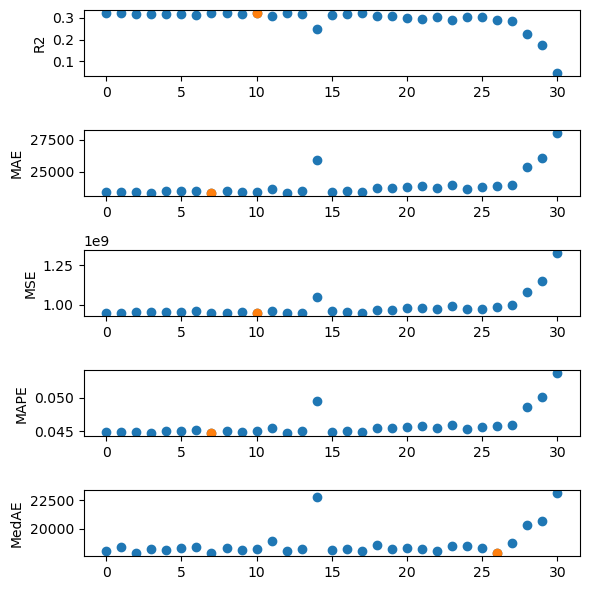

In [89]:
fig, ax = plt.subplots(len(metric_names), 1, figsize=(6,6))
for i in range(len(metric_names)):
    scores = [x[i] for x in all_scores]
    if i == 0:
        best_score = np.max(scores)
    else:
        best_score = np.min(scores)
        
    ax[i].scatter(range(len(scores)), scores)
    ax[i].scatter(np.where(scores == best_score)[0][0], best_score)
    
    ax[i].set_ylabel(metric_names[i])
plt.tight_layout()

In [107]:
print(to_drop[7], to_drop[10], to_drop[26])

hdd3 cdd Index(['cdd3', 'cdd4', 't2m4', 'hdd4', 'mtpr', 't2m3', 'rh', 'hdd3', 'w10',
       't2min'],
      dtype='object')


In [116]:
[i for i in predictors if i not in to_drop[26]]

['is_weekend', 'msdwswrf', 't2m', 'cdd', 'hdd', 't2max']

In [120]:
def ts_scatter(ax0, ax1, pred, model_label):
    """
    Time series and scatter plot of predictions against obs
    """
    ax0.plot(test_y, label="Obs")
    ax0.plot(pred, label=model_label)
    ax0.legend()
    ax0.set_ylabel("Demand [MWh/day]")

    ax1.scatter(pred, test_y)
    ax1.plot(np.arange(4.5e5, 6.5e5, 100), np.arange(4.5e5, 6.5e5, 100), color="k", ls="--")
    ax1.set_xlabel("Predicted [MWh/day]")
    ax1.set_ylabel("Observed [MWh/day]")

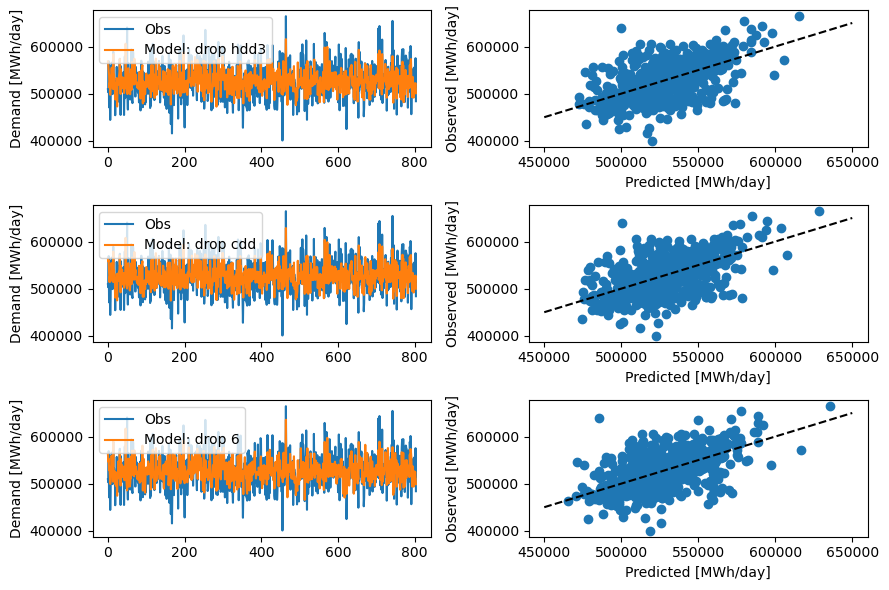

In [121]:
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

for i, (p, l) in enumerate(zip(
    [models[7][0], models[10][0], models[26][0]],
    ["Model: drop hdd3", "Model: drop cdd", "Model: drop 6"]
)):
    ts_scatter(ax[i,0], ax[i,1], p, l)
plt.tight_layout()